# EDA, Text, Processing, and Feature Engineering

In [38]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

# text processing
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from textblob import TextBlob as tb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models
import scipy.sparse

# miscellany
import re
import string
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load in DataFrame

In [2]:
df = pd.read_csv('data/poetry_foundation_clean.csv', index_col=0)
df.head()

,poet_url,genre,poem_url,poet,title,poem_lines,poem_string,clean_lines,num_lines,avg_len_line
0,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48578/at-the-california-institute-of-technology,Richard Brautigan,At the California Institute of Technology,"['I don’t care how God-damn smart', '\r these guys are: I’m bored.', '', '\r It’s been raining like hell all day long', '\r and there’s nothing to...",I don’t care how God-damn smart\n\r these guys are: I’m bored.\n\n\r It’s been raining like hell all day long\n\r and there’s nothing to do.\n,"['I don’t care how God-damn smart', 'these guys are: I’m bored.', 'It’s been raining like hell all day long', 'and there’s nothing to do.']",4,6.000000
1,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48576/a-boat,Richard Brautigan,A Boat,"['O beautiful ', 'was the werewolf ', 'in his evil forest. ', 'We took him ', 'to the carnival ', 'and he started ', ' crying ', 'when h...",O beautiful \nwas the werewolf \nin his evil forest. \nWe took him \nto the carnival \nand he started \n crying \nwhen he saw \nthe Ferr...,"['O beautiful', 'was the werewolf', 'in his evil forest.', 'We took him', 'to the carnival', 'and he started', 'crying', 'when he saw', 'the Ferri...",17,2.647059
2,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48580/december-30,Richard Brautigan,December 30,"['At 1:03 in the morning a fart', '\r smells like a marriage between', '\r an avocado and a fish head.', '', '\r I have to get out of bed', '\r to...",At 1:03 in the morning a fart\n\r smells like a marriage between\n\r an avocado and a fish head.\n\n\r I have to get out of bed\n\r to write this ...,"['At 1:03 in the morning a fart', 'smells like a marriage between', 'an avocado and a fish head.', 'I have to get out of bed', 'to write this down...",6,5.500000
3,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48579/the-double-bed-dream-gallows,Richard Brautigan,The Double-Bed Dream Gallows,"['Driving through ', '\r hot brushy country', '\r in the late autumn, ', '\r I saw a hawk', '\r crucified on a', '\r barbed-wire fence.', '', ...","Driving through \n\r hot brushy country\n\r in the late autumn, \n\r I saw a hawk\n\r crucified on a\n\r barbed-wire fence.\n\n\r I guess as a...","['Driving through', 'hot brushy country', 'in the late autumn,', 'I saw a hawk', 'crucified on a', 'barbed-wire fence.', 'I guess as a kind', 'of ...",17,3.176471
4,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48581/haiku-ambulance,Richard Brautigan,Haiku Ambulance,"['A piece of green pepper', '\r fell', '\r off the wooden salad bowl:', '\r so what?', '']",A piece of green pepper\n\r fell\n\r off the wooden salad bowl:\n\r so what?\n,"['A piece of green pepper', 'fell', 'off the wooden salad bowl:', 'so what?']",4,3.250000


In [3]:
df.shape

(4291, 10)

#### Saving to CSV converts the poem_lines lists into a string, so we'll use our destringify function to convert it back to a list format.

In [4]:
df.loc[0,'poem_lines']

"['I don’t care how God-damn smart', '\\r these guys are: I’m bored.', '', '\\r It’s been raining like hell all day long', '\\r and there’s nothing to do.', '']"

In [5]:
df['poem_lines'] = df['poem_lines'].apply(destringify)
df.loc[0,'poem_lines']

['I don’t care how God-damn smart',
 '\r these guys are: I’m bored.',
 '',
 '\r It’s been raining like hell all day long',
 '\r and there’s nothing to do.',
 '']

In [6]:
df['clean_lines'] = df['clean_lines'].apply(destringify)
df.loc[0,'clean_lines']

['I don’t care how God-damn smart',
 'these guys are: I’m bored.',
 'It’s been raining like hell all day long',
 'and there’s nothing to do.']

In [53]:
df.loc[3093]

poet_url                                         https://www.poetryfoundation.org/poets/aram-saroyan
genre                                                                 new_york_school_2nd_generation
poem_url                        https://www.poetryfoundation.org/poetrymagazine/poems/30726/wind-oil
poet                                                                                    Aram Saroyan
title                                                                                       Wind Oil
poem_lines                                  [seek, air, tragedy, bodies, wind oil to, blows out sea]
poem_string                                   seek\nair\ntragedy\nbodies\nwind oil to\nblows out sea
clean_lines                                 [seek, air, tragedy, bodies, wind oil to, blows out sea]
num_lines                                                                                          6
avg_len_line                                                                               

##### Let's look at our class imbalance.

In [7]:
# number of poems per genre
df.genre.value_counts()

modern                            1136
victorian                          643
romantic                           397
imagist                            315
new_york_school                    239
black_mountain                     234
language_poetry                    191
new_york_school_2nd_generation     177
black_arts_movement                162
georgian                           158
confessional                       153
harlem_renaissance                 142
beat                               138
objectivist                        132
fugitive                            74
Name: genre, dtype: int64

In [8]:
# percentage of total poems by genre
df.genre.value_counts(normalize=True)

modern                            0.264740
victorian                         0.149849
romantic                          0.092519
imagist                           0.073409
new_york_school                   0.055698
black_mountain                    0.054533
language_poetry                   0.044512
new_york_school_2nd_generation    0.041249
black_arts_movement               0.037753
georgian                          0.036821
confessional                      0.035656
harlem_renaissance                0.033093
beat                              0.032160
objectivist                       0.030762
fugitive                          0.017245
Name: genre, dtype: float64

In [9]:
# cumulative percentage of total poems by genre
df.genre.value_counts(normalize=True).cumsum()

modern                            0.264740
victorian                         0.414589
romantic                          0.507108
imagist                           0.580517
new_york_school                   0.636215
black_mountain                    0.690748
language_poetry                   0.735260
new_york_school_2nd_generation    0.776509
black_arts_movement               0.814262
georgian                          0.851084
confessional                      0.886740
harlem_renaissance                0.919832
beat                              0.951993
objectivist                       0.982755
fugitive                          1.000000
Name: genre, dtype: float64

In [10]:
# number of unique poets per genre
{genre:len(poets) for genre,poets in df.groupby('genre').poet.unique().items()}

{'beat': 13,
 'black_arts_movement': 18,
 'black_mountain': 10,
 'confessional': 9,
 'fugitive': 7,
 'georgian': 18,
 'harlem_renaissance': 14,
 'imagist': 7,
 'language_poetry': 14,
 'modern': 52,
 'new_york_school': 10,
 'new_york_school_2nd_generation': 16,
 'objectivist': 5,
 'romantic': 50,
 'victorian': 56}

## Initial feature creation
#### Number of lines column -- first clean up the lines, then count them

In [385]:
df.loc[0,'poem_lines']

['I don’t care how God-damn smart',
 '\r these guys are: I’m bored.',
 '',
 '\r It’s been raining like hell all day long',
 '\r and there’s nothing to do.',
 '']

In [386]:
df['clean_lines'] = df.poem_lines.apply(line_cleaner)

In [387]:
df.loc[0,'clean_lines']

['I don’t care how God-damn smart',
 'these guys are: I’m bored.',
 'It’s been raining like hell all day long',
 'and there’s nothing to do.']

In [388]:
df['num_lines'] = df.clean_lines.apply(lambda x: len(x))

In [389]:
df.loc[0,'num_lines']

4

#### Use function to obtain average line length

In [390]:
line_averager(df.loc[0,'clean_lines'])

6.0

In [391]:
df['avg_len_line'] = df.clean_lines.apply(line_averager)

#### Let's look at our new continuous variables, as a whole and by genre

In [11]:
# number of lines and average length of line as a whole
df.describe()

,num_lines,avg_len_line
count,4291.000000,4291.000000
mean,36.320671,6.838280
std,60.071109,13.770607
min,1.000000,1.000000
25%,14.000000,5.027778
50%,21.000000,6.227273
75%,32.000000,7.452027
max,892.000000,808.000000


In [12]:
# number of lines by genre
df.groupby('genre').num_lines.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,138.000000,162.000000,234.000000,153.000000,74.000000,158.000000,142.000000,315.000000,191.000000,1136.000000,239.000000,177.000000,132.000000,397.000000,643.000000
mean,43.355072,41.938272,29.880342,42.320261,28.270270,23.949367,24.169014,23.942857,35.560209,24.395246,32.338912,39.367232,42.303030,55.465995,55.912908
std,54.772229,33.790125,32.050567,61.581958,40.220726,18.484560,32.455310,29.659263,45.982666,36.322825,33.312220,47.325465,57.186175,100.420389,95.087786
min,4.000000,1.000000,3.000000,4.000000,5.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,5.000000,4.000000,1.000000
25%,17.000000,21.000000,15.250000,18.000000,14.000000,13.250000,12.000000,11.000000,18.000000,12.000000,18.500000,15.000000,15.000000,14.000000,15.000000
50%,25.500000,31.000000,23.000000,26.000000,20.000000,19.000000,16.000000,19.000000,24.000000,18.000000,25.000000,23.000000,23.000000,24.000000,24.000000
75%,43.750000,54.750000,29.000000,42.000000,27.000000,26.000000,24.000000,24.000000,36.000000,24.000000,33.500000,40.000000,38.500000,49.000000,52.000000
max,331.000000,157.000000,256.000000,515.000000,323.000000,143.000000,249.000000,256.000000,476.000000,605.000000,383.000000,289.000000,410.000000,810.000000,892.000000


In [13]:
# average length of line by genre
df.groupby('genre').avg_len_line.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,138.000000,162.000000,234.000000,153.000000,74.000000,158.000000,142.000000,315.000000,191.000000,1136.000000,239.000000,177.000000,132.000000,397.000000,643.000000
mean,6.810101,6.699416,5.090879,6.590835,7.459002,6.687811,6.291038,6.067738,6.975177,6.672186,7.744362,11.552095,4.772828,6.822324,7.090248
std,4.595840,6.982837,6.440844,1.504047,1.099102,1.435607,3.608594,7.343963,17.999521,6.262389,4.390220,60.964000,1.789607,1.217709,1.778890
min,1.307692,2.840000,1.571429,2.888889,4.607143,3.500000,1.801136,1.421053,1.000000,1.333333,2.523810,1.000000,1.578947,3.600000,3.375000
25%,4.731410,4.711180,3.597222,5.657143,7.008621,5.666667,4.535059,4.074176,3.183333,5.129076,5.953347,4.538462,3.520790,5.931818,5.958896
50%,5.646259,5.776786,4.500000,6.416667,7.464461,6.569712,5.781746,5.166667,4.411765,6.176786,7.175000,6.400000,4.468528,6.833333,6.798077
75%,7.120074,7.282468,5.589286,7.450000,8.077110,7.757500,7.383929,6.250000,7.328829,7.292279,8.309524,8.055556,6.088942,7.641026,8.000000
max,32.181818,88.000000,100.500000,16.340708,11.250000,13.500000,33.800000,105.666667,235.000000,139.000000,42.500000,808.000000,8.920000,11.791667,22.500000


### Let's look at some boxplots of this information

### Number of lines -- Boxplot

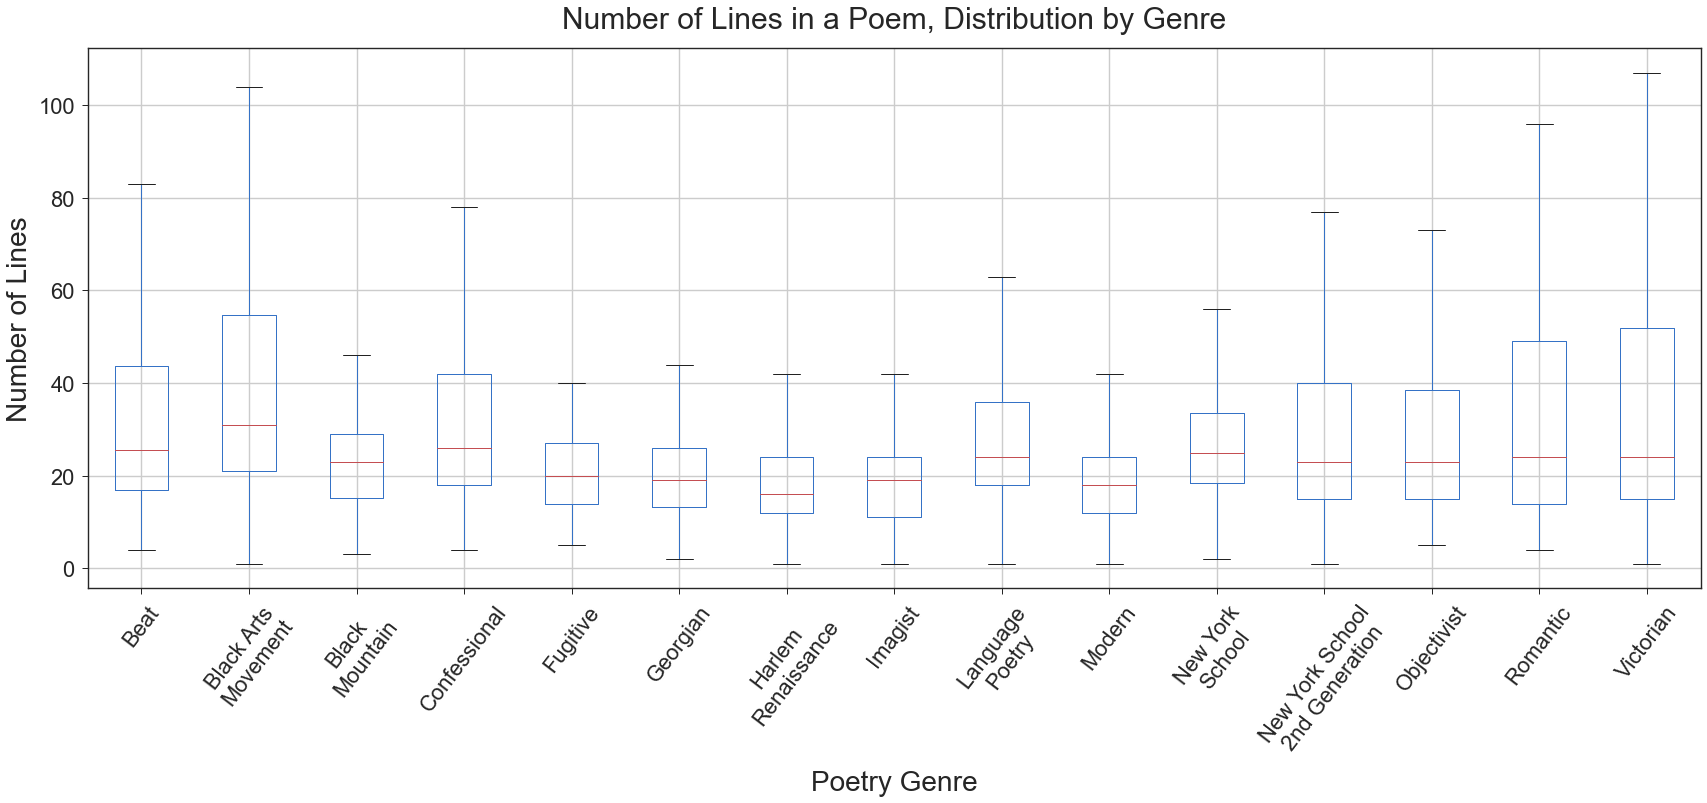

In [14]:
sns.set_style('ticks')

df.boxplot('num_lines', 'genre', showfliers=False, figsize=(28,10))
plt.title('Number of Lines in a Poem, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('Number of Lines', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

#### Some promise here, though the medians look fairly similar

### Average Line Length -- Boxplot

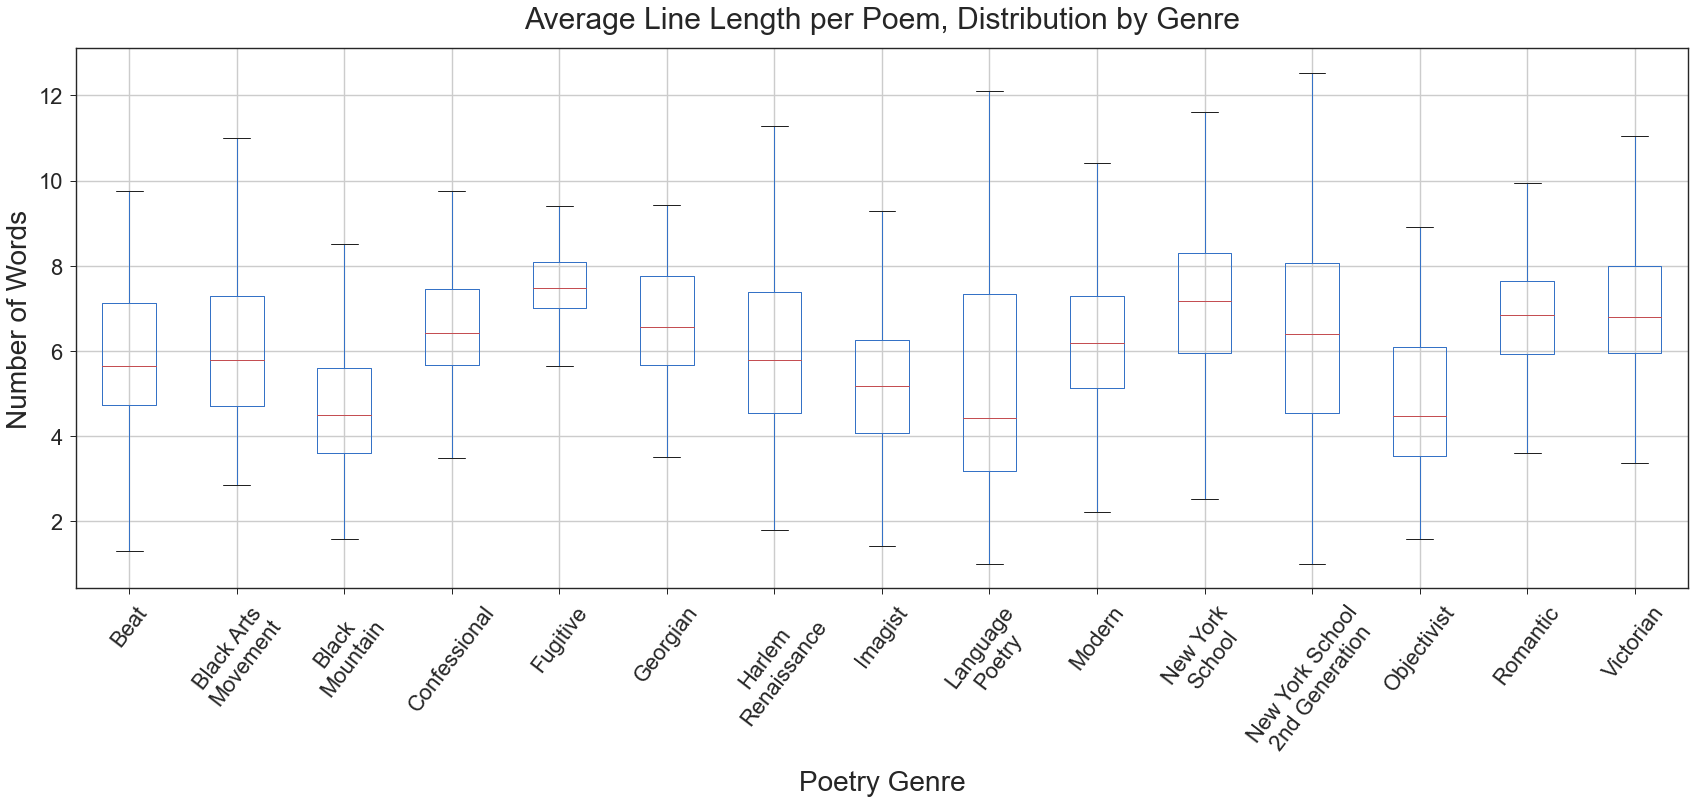

In [15]:
df.boxplot('avg_len_line', 'genre', showfliers=False, figsize=(28,10))
plt.title('Average Line Length per Poem, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('Number of Words', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

#### Average line length appears to be very telling
### A look at polarity by genre

In [16]:
# instantiate VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create a column with the compound polarity score, passing in the raw poem
df['sentiment_polarity_score'] = df['poem_string'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [17]:
# may be handy to also have this as a categorical variable
conditions = [
    df.sentiment_polarity_score >= .05,
    df.sentiment_polarity_score <= -.05
]

choices = [
    'positive',
    'negative'
]

df['sentiment_polarity'] = np.select(conditions, choices, 'neutral')

In [18]:
# polarity score by genre
df.groupby('genre').sentiment_polarity_score.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,138.000000,162.000000,234.000000,153.000000,74.000000,158.000000,142.000000,315.000000,191.000000,1136.000000,239.000000,177.000000,132.000000,397.000000,643.000000
mean,0.180228,0.015506,0.291073,0.100346,0.115300,0.028245,0.143812,0.256555,0.159160,0.204777,0.416221,0.371677,0.103570,0.510343,0.362324
std,0.751962,0.820797,0.645880,0.787721,0.754913,0.789046,0.753233,0.661848,0.650638,0.711573,0.674478,0.688377,0.709490,0.718027,0.785232
min,-0.999800,-0.999400,-0.998200,-0.997000,-0.996200,-0.998000,-0.998700,-0.997900,-0.996500,-0.998100,-0.985900,-0.998600,-0.992100,-0.999700,-0.999900
25%,-0.631100,-0.894900,-0.187500,-0.782500,-0.703500,-0.835450,-0.608875,-0.317050,-0.443750,-0.518800,-0.226300,-0.064400,-0.620200,0.250000,-0.517650
50%,0.381800,0.177900,0.502250,0.343000,0.318700,0.000000,0.327550,0.491200,0.277200,0.453000,0.790600,0.673700,0.176900,0.937800,0.864500
75%,0.921550,0.856725,0.864600,0.895200,0.873850,0.918675,0.887325,0.863450,0.784250,0.878175,0.953000,0.944800,0.821025,0.987800,0.980650
max,0.997600,0.998200,0.996300,0.999900,0.999600,0.998100,0.995900,0.997900,0.996100,0.999900,0.999700,0.999500,0.998100,1.000000,1.000000


### Polarity score -- Boxplot

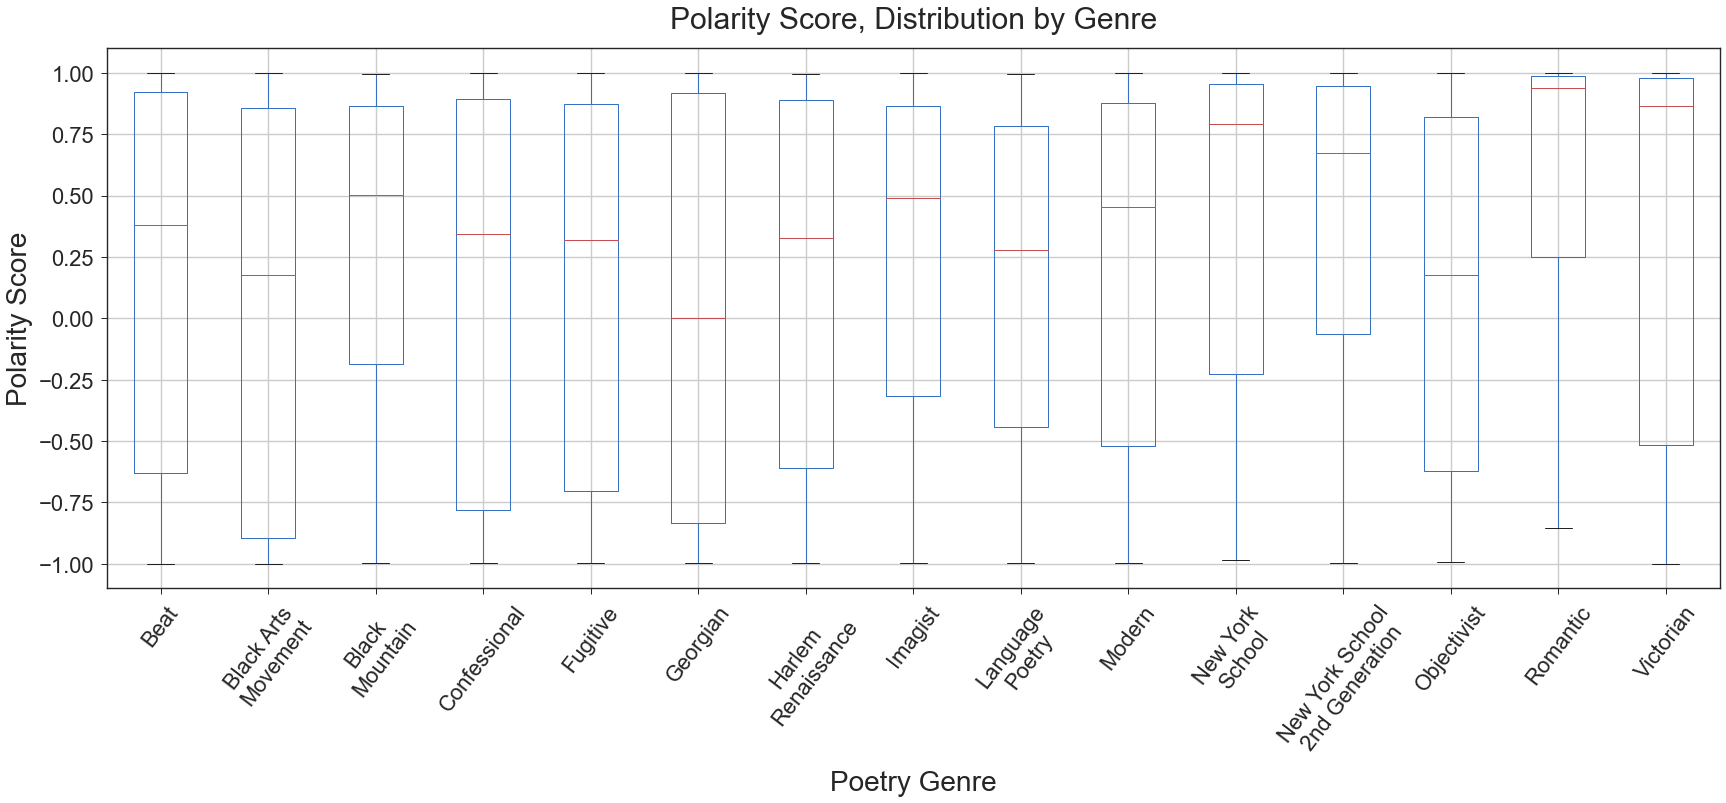

In [19]:
df.boxplot('sentiment_polarity_score', 'genre', showfliers=False, figsize=(28,10))
plt.title('Polarity Score, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('Polarity Score', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

#### Some definitely telling differences in polarity here

### Polarity -- Stacked bar chart

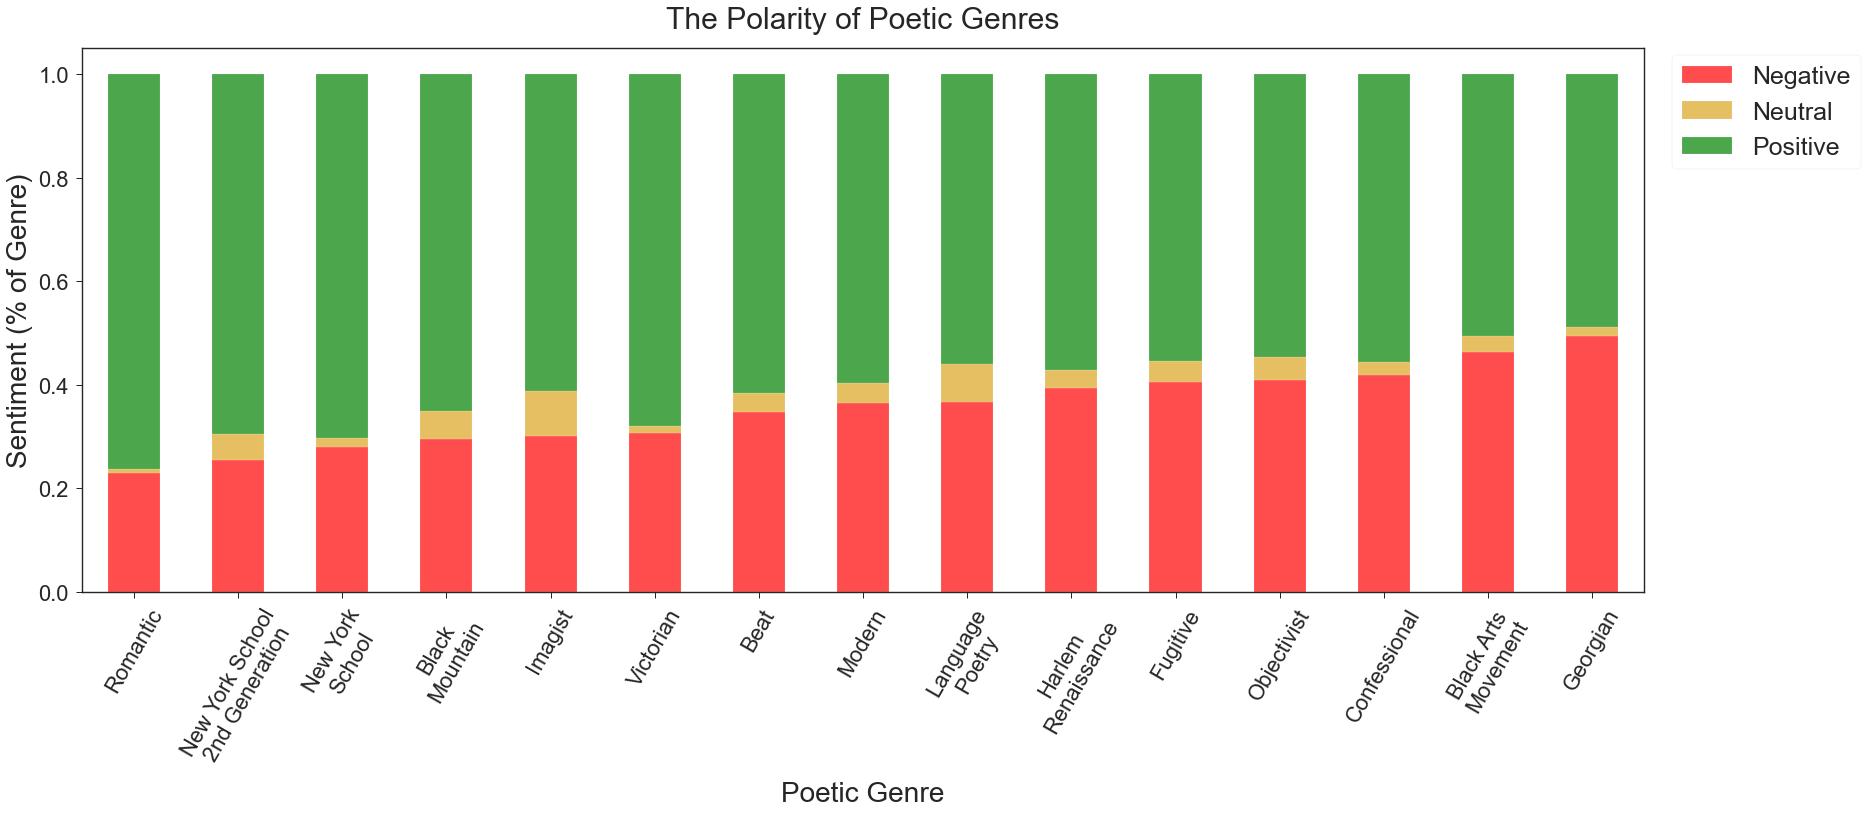

In [20]:
# Proportion of polarity across genre
genre_polarity_dist = df.groupby('genre').sentiment_polarity.value_counts(normalize=True).unstack().sort_values('negative')

genre_polarity_dist.plot(kind='bar', stacked = True, figsize=(28,10), 
                               color = ['red', 'goldenrod', 'green'], alpha = .70, fontsize=14)


plt.title('The Polarity of Poetic Genres', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetic Genre', fontsize=28, labelpad=10)
plt.ylabel('Sentiment (% of Genre)', fontsize=28, labelpad=5)

# obtain x-tick-labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-2] = 'Black Arts\nMovement'
labels_pretty[2] = 'New York\nSchool'
labels_pretty[1] = 'New York School\n2nd Generation'

plt.xticks(ticks=locs, labels=labels_pretty, rotation=60, fontsize=22)

plt.yticks(fontsize=22);

plt.legend(['Negative', 'Neutral', 'Positive'], facecolor='white', framealpha=1, bbox_to_anchor=(1.01, 1.01),
          fontsize=25);

#### Polarity differences made even more clear here

### A look at subjectivity by genre

In [21]:
# create a column with the compound polarity score, passing in the raw poem
df['sentiment_subjectivity_score'] = df['poem_string'].apply(lambda x: tb(x).sentiment.subjectivity)

# a look at subjectivity score overall
df.sentiment_subjectivity_score.describe()

count    4291.000000
mean        0.477031
std         0.141894
min         0.000000
25%         0.407143
50%         0.484019
75%         0.552440
max         1.000000
Name: sentiment_subjectivity_score, dtype: float64

In [22]:
# subjectivity score by genre
df.groupby('genre').sentiment_subjectivity_score.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,138.000000,162.000000,234.000000,153.000000,74.000000,158.000000,142.000000,315.000000,191.000000,1136.000000,239.000000,177.000000,132.000000,397.000000,643.000000
mean,0.485246,0.484068,0.475265,0.448935,0.459595,0.493666,0.461042,0.461710,0.448561,0.473963,0.475594,0.457006,0.457039,0.516871,0.489208
std,0.137882,0.136350,0.136952,0.094966,0.098724,0.136663,0.167704,0.181687,0.165731,0.157108,0.109330,0.145295,0.164797,0.111731,0.107615
min,0.000000,0.000000,0.000000,0.000000,0.244004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.407912,0.403779,0.393784,0.397436,0.400128,0.413955,0.375000,0.377407,0.386667,0.391857,0.414911,0.404615,0.365916,0.462847,0.433160
50%,0.500000,0.495207,0.466667,0.454464,0.455928,0.493743,0.478091,0.466667,0.456031,0.483333,0.471914,0.472128,0.473405,0.518158,0.500000
75%,0.569699,0.548734,0.561296,0.516667,0.531264,0.571404,0.551786,0.569259,0.544205,0.560694,0.534637,0.529274,0.537731,0.569872,0.542774
max,1.000000,1.000000,1.000000,0.659259,0.683333,1.000000,0.888889,0.933333,1.000000,1.000000,1.000000,0.900000,1.000000,0.950000,0.944444


### Subjectivity score -- Boxplot

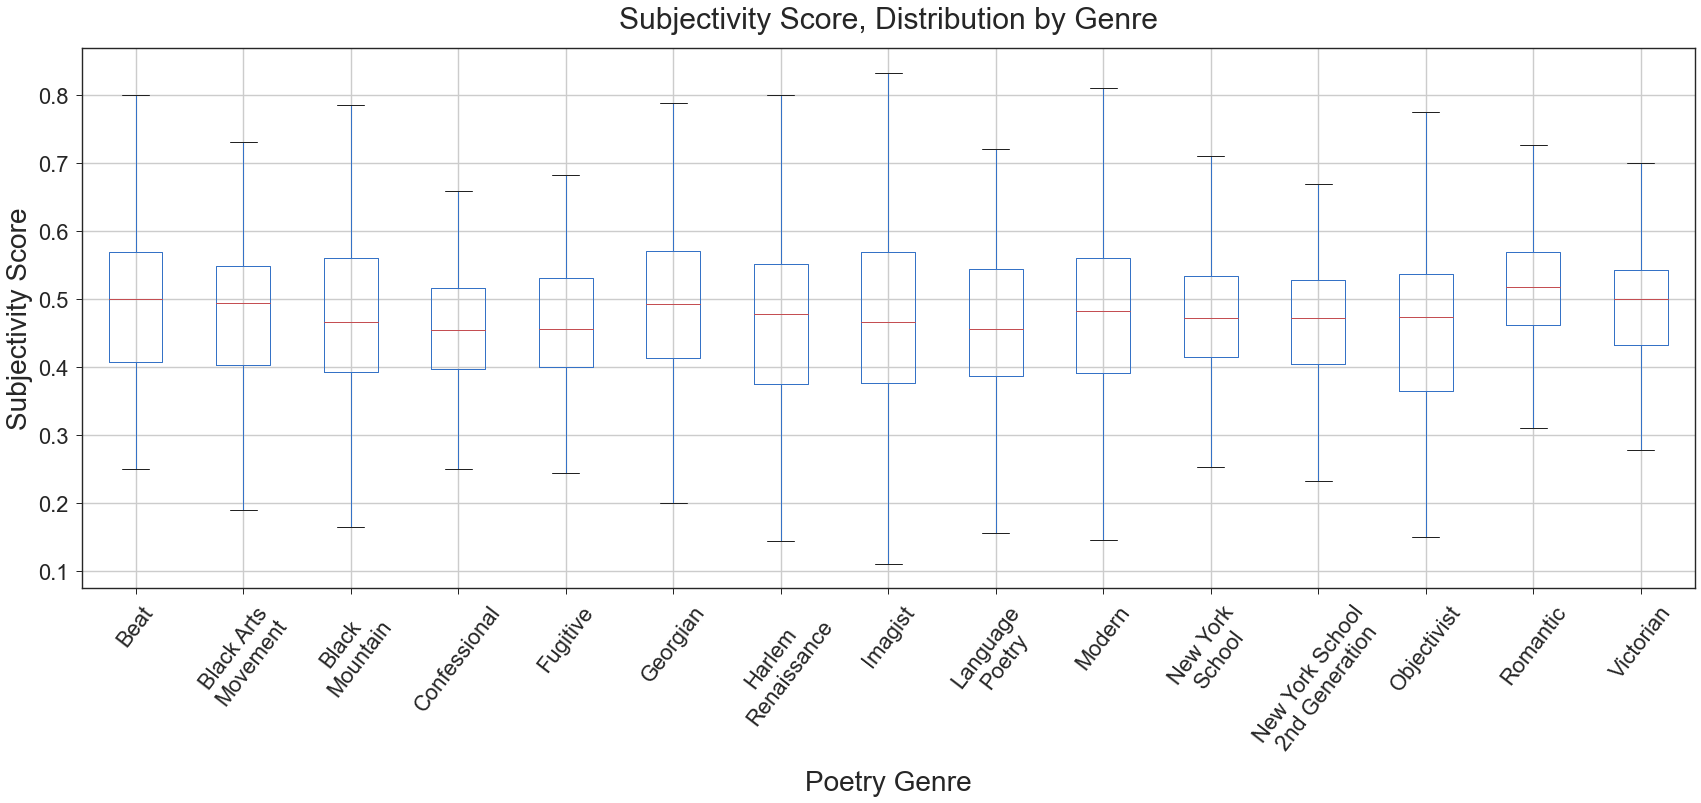

In [23]:
df.boxplot('sentiment_subjectivity_score', 'genre', showfliers=False, figsize=(28,10))
plt.title('Subjectivity Score, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('Subjectivity Score', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

#### Subjectivity seems fairly similar across all genres

## Text Processing
#### First, let's save our dataframe (I'll be pickling now to try to avoid having to destringify columns)

In [33]:
# # uncomment to save
# with gzip.open('data/poetry_genres_df.pkl', 'wb') as goodbye:
#     pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# uncomment to load
with gzip.open('data/poetry_genres_df.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [34]:
df.columns

Index(['poet_url', 'genre', 'poem_url', 'poet', 'title', 'poem_lines',
       'poem_string', 'clean_lines', 'num_lines', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score'],
      dtype='object')

#### Then we can separate our target variable and creating a features dataframe 

In [35]:
target = df['genre']
features = df[['title', 'clean_lines', 'num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_polarity',
               'sentiment_subjectivity_score']]

In [39]:
# since I'll be treating the title as part of the poem, combine title and lines
# NOTE: a pesky float ValueError solved by casting str() on values, even though it seems like everything was a string already
features['lines_titled'] = features['title'].apply(lambda x: [str(x)]) + features['clean_lines']
features.loc[2,'lines_titled']

['December 30',
 'At 1:03 in the morning a fart',
 'smells like a marriage between',
 'an avocado and a fish head.',
 'I have to get out of bed',
 'to write this down without',
 'my glasses on.']

In [40]:
features['string_titled'] = features.lines_titled.apply(lambda x: ' '.join(x))
features.loc[2,'string_titled']

'December 30 At 1:03 in the morning a fart smells like a marriage between an avocado and a fish head. I have to get out of bed to write this down without my glasses on.'

#### Now we can drop the title and clean_lines columns

In [42]:
features.drop(columns=['title', 'clean_lines'], inplace=True)
features.columns

Index(['num_lines', 'avg_len_line', 'sentiment_polarity_score',
       'sentiment_polarity', 'sentiment_subjectivity_score', 'lines_titled',
       'string_titled'],
      dtype='object')

In [47]:
df[df.poem_string.str.contains('<')]

,poet_url,genre,poem_url,poet,title,poem_lines,poem_string,clean_lines,num_lines,avg_len_line,sentiment_polarity_score,sentiment_polarity,sentiment_subjectivity_score
225,https://www.poetryfoundation.org/poets/nikki-giovanni,black_arts_movement,https://www.poetryfoundation.org/poems/90181/no-complaints,Nikki Giovanni,No Complaints,"[, <div class=""c-epigraph"">\n<p>\n<div style=""font-style:italic;""><p><span style=""font-style:normal"">(For Gwendolyn Brooks, 1917—2001)</span></p><...","\n<div class=""c-epigraph"">\n<p>\n<div style=""font-style:italic;""><p><span style=""font-style:normal"">(For Gwendolyn Brooks, 1917—2001)</span></p></...","[<div class=""c-epigraph"">\n<p>\n<div style=""font-style:italic;""><p><span style=""font-style:normal"">(For Gwendolyn Brooks, 1917—2001)</span></p></d...",1,11.000000,0.0000,neutral,0.000000
235,https://www.poetryfoundation.org/poets/etheridge-knight,black_arts_movement,https://www.poetryfoundation.org/poems/51371/a-fable-56d22f0fa5920,Etheridge Knight,A Fable,[Once upon a today and yesterday and nevermore there were 7 men and women all locked / up in prison cells. Now these 7 men and women were innocent...,Once upon a today and yesterday and nevermore there were 7 men and women all locked / up in prison cells. Now these 7 men and women were innocent ...,[Once upon a today and yesterday and nevermore there were 7 men and women all locked / up in prison cells. Now these 7 men and women were innocent...,11,31.090909,-0.9925,negative,0.598452
933,https://www.poetryfoundation.org/poets/w-e-b-du-bois,harlem_renaissance,https://www.poetryfoundation.org/poems/43026/my-country-tis-of-thee,W. E. B. Du Bois,My Country ’Tis of Thee,"[Of course you have faced the dilemma: it is announced, they all smirk and rise. If they are, <em>ultra,</em>, they remove their hats and look ecs...","Of course you have faced the dilemma: it is announced, they all smirk and rise. If they are\n<em>ultra,</em>\nthey remove their hats and look ecst...","[Of course you have faced the dilemma: it is announced, they all smirk and rise. If they are, <em>ultra,</em>, they remove their hats and look ecs...",37,6.243243,0.9940,positive,0.607870
1281,https://www.poetryfoundation.org/poets/william-carlos-williams,imagist,https://www.poetryfoundation.org/poems/54525/kora-in-hell-improvisations-ii,William Carlos Williams,Kora in Hell: Improvisations II,"[, <div class=""c-epigraph"">\n<p>\n<div style=""font-style:italic;"">To Flossie</div>\n</p>\n</div>, ]","\n<div class=""c-epigraph"">\n<p>\n<div style=""font-style:italic;"">To Flossie</div>\n</p>\n</div>\n","[<div class=""c-epigraph"">\n<p>\n<div style=""font-style:italic;"">To Flossie</div>\n</p>\n</div>]",1,8.000000,0.0000,neutral,0.000000
1480,https://www.poetryfoundation.org/poets/lyn-hejinian,language_poetry,https://www.poetryfoundation.org/poems/47893/my-life-reason-looks-for-two-then-arranges-it-from-there,Lyn Hejinian,"My Life: Reason looks for two, then arranges it from there","[<em>Reason looks for</em>, Where I woke and was awake, in the, <em>two, then</em>, room fitting the wall, withdrawn, I, <em>arranges it</em>, had...","<em>Reason looks for</em>\nWhere I woke and was awake, in the\n<em>two, then</em>\nroom fitting the wall, withdrawn, I\n<em>arranges it</em>\nhad ...","[<em>Reason looks for</em>, Where I woke and was awake, in the, <em>two, then</em>, room fitting the wall, withdrawn, I, <em>arranges it</em>, had...",60,9.350000,-0.9354,negative,0.500264
1496,https://www.poetryfoundation.org/poets/fanny-howe,language_poetry,https://www.poetryfoundation.org/poems/46763/you-cant-warm-your-hands-in-front-of-a-book-but-you-can-warm-your-hopes-there,Fanny Howe,You Can’t Warm Your Hands in Front of a Book but You Can Warm Your Hopes There,[Feathers fluffed the ashtray bin at the bottom of the elevator. Feathers and a smeared black look littered the parking lot like mascara. A cage w...,Feathers fluffed the ashtray bin at the bottom of the elevator. Feathers and a smeared

In [ ]:
# start with NLTK stop words
stop_words = stopwords.words('english')

In [ ]:
# Apply text cleaning techniques
def clean_text(text, stop_words):
    '''Make text lowercase, remove mentions, remove links, convert emoticons/emojis to words, remove punctuation
    (except apostrophes), tokenize words (including contractions), convert contractions to full words,
    remove stop words.'''
    
    # make text lowercase
    text = text.lower() 
    
    # remove mentions
    text = re.sub("(@[A-Za-z0-9]+)", "", text)
    
    # remove links
    text = re.sub(r'http\S+', '', text) 
    text = re.sub(r'pic\.\S+', '', text)
    
    # convert emoticons
    emoticons = load_dict_emoticons()
    words = text.split()
    words_edit = [emoticons[word] if word in emoticons else word for word in words]
    tweet = ' '.join(words_edit)

    # convert emojis
    text = emoji.demojize(text)
    text = text.replace(':', ' ') # separate emojis-words with space
    
    # remove punctuation
    text = text.replace('...', ' ') # special cases
    text = text.replace('-', ' ')
    text = text.translate(str.maketrans('', '', '!"$%&*()+,./;<=>?@[\\]^_`{|}~')) 
    
    # tokenize words
    tokenizer = RegexpTokenizer("(#?[a-zA-Z]+[0-9]*(?:'[a-zx]+)?)")
    words = tokenizer.tokenize(text)
    
    # convert contractions
    contractions = load_dict_contractions()
    words = text.split()
    words_edit = [contractions[word] if word in contractions else word for word in words]
    text = ' '.join(words_edit)

    # remove stop words and lemmatize
    lemmatizer = WordNetLemmatizer()
    words = tokenizer.tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    text = ' '.join(words)
    
    return text

### First go at vectorizing -- TF-IDF Vectorizer